## Import datas

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Use pandas to loadinto a DataFrame
# Y1.csv doesn’t have a header so
# add one when loading the file
X1 = pd.read_csv("data/X1.csv")
Y1 = pd.read_csv("data/Y1.csv", header=None, names=['revenue'])


# ENLEVER colonne "Unnamed" du dataset : utilité ? -> Pas listé dans les features du pdf
X = X1.drop(['Unnamed: 0', 'img_url', 'description'], axis=1)

### Pre data visualisation

           ratings       n_votes  is_adult  production_year  release_year
count  3540.000000  3.540000e+03    3540.0      3540.000000   3540.000000
mean      6.426582  2.337422e+04       0.0      1996.867232   2001.375706
std       1.166002  8.597705e+04       0.0        11.818582      9.236620
min       1.100000  5.000000e+00       0.0      1916.000000   1941.000000
25%       5.800000  1.577500e+02       0.0      1992.000000   1996.000000
50%       6.500000  1.412000e+03       0.0      2000.000000   2003.000000
75%       7.200000  9.424500e+03       0.0      2005.000000   2007.000000
max      10.000000  2.332286e+06       0.0      2019.000000   2018.000000


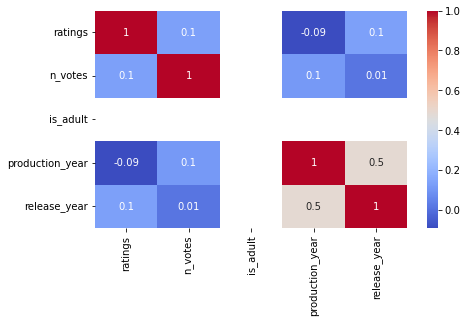

In [3]:
print(X.describe())

plt.figure(figsize=(7,4))
corr = X.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.1g')

## Preprocessing the data
### Preprocessing functions

In [4]:
"""
Creating empty DataFrame to start
"""
n_samples = X.shape[0]
data = pd.DataFrame()

In [5]:
"""
Keeping the directly usable features
"""
def get_directrly_usable_features(df):
    directly_usable_features = ["ratings", "n_votes", "is_adult"]
    for feature in directly_usable_features:
        df[feature] = X[feature]
    return df

In [6]:
"""
Dealing with the "production_year" feature
"""

def get_prod_year_feature(df, params):
    
    style = params["production_year_style"] # "per_quantile" / "per_period_length" / "no_period"
    if style != "no_period" :
        n_year_period = params["n_year_period"]

    # Removing previously computed categorie(s) for the "production_year" initial feature

    for feature in df.columns:
        if len(feature) >= 8 and (feature[:6] == "period" or feature == "production_year"):
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "production_year" initial feature

    prod_year = X["production_year"].copy()
    if style == "per_quantile" or style == "per_period_length":
        categories = np.ones((n_year_period, n_samples))

        if style == "per_quantile":
            thresholds = prod_year.quantile(np.arange(1, n_year_period) / n_year_period)
        else :
            thresholds = np.min(prod_year) + (np.max(prod_year) - np.min(prod_year))*np.arange(1, n_year_period)/n_year_period
        for i, threshold in enumerate(thresholds):
            categories[i+1] = (prod_year >= threshold).astype(int)
            categories[i] -= categories[i+1]
        for period in range(n_year_period):
            df["period {}".format(period)] = categories[period]
    elif style == "no_period":
        df["production_year"] = prod_year
    return df

In [7]:
"""
Dealing with the "runtime" feature

The problem is here that we have some missing values, we have to deal with it.
"""

def get_runtime_feature(df, params):

    # Add other smarter ways ?
    
    replace_type = params["runtime_replace_type"] # "zero" / "mean"
    
    runtime = X["runtime"].copy()
    if replace_type == "zero":
        runtime[runtime == "\\N"] = 0
    if replace_type == "mean":
        mean = np.mean(runtime[runtime != "\\N"].astype(float))
        runtime[runtime == "\\N"] = mean
    df["runtime"] = runtime.astype(float)    
    return df

In [8]:
"""
Dealing with the "studio" feature


Juste rajouter toute les features une par une me semblait un peu lourd (yen a 509), ducoup j'effectue PCA dessus.
Jsp si ça se fait ? (on peut changer l'algo de dimensionality reduction aussi si on veut)
"""

def get_studio_feature(df, params):
    
    
    use_PCA = params["studio_use_PCA"]
    if use_PCA :
        dim = params["studio_PCA_dim"]


    # Removing previously computed categorie(s) for the "studio" initial feature
    for feature in df.columns:
        if len(feature) >= 10 and feature[:10] == "studio_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "studio" initial feature
    studio = X["studio"].copy()
    studio_labels = np.unique(studio)
    studio_features = np.zeros((len(studio_labels), n_samples))
    for i, label in enumerate(studio_labels) :
        studio_features[i] = (studio == label).astype(int)

    # Applying pca or not
    if use_PCA :
        pca = PCA(n_components=dim)
        out = pca.fit_transform(studio_features.T)
    else :
        out = studio_features.T

    df[["studio_PC_{}".format(i) for i in range(dim)]] = out
    return df

# Ya plein de warnings quand dim trop grand ou pas de PCA /: 
# jsp comment regler ça... en utilisant pd.concat ça tourne vraiment extrêmement lentement

In [9]:
"""
Dealing with the "genres" feature

Je rajoute juste une feature par genre, j'espère ça suffit ? -> pt-être dimension reduction sur ça aussi ?
Certains films ont pas de genre attitré (genre = "\\N"),
ce que j'ai fait ici considère ça comme un genre à part entière, ptet on peut deal le truc autrement ?
"""

def get_genre_feature(df):

    X.loc[X["genres"] == "\\N", "genres"] = "Others"
    all_genres = X["genres"].copy()
    diff_genres = []

    for genres in np.unique(all_genres):
        for genre in genres.split(",") :
            if not genre in diff_genres :
                diff_genres.append(genre)

    for genre in diff_genres:
        df[genre] = [1 if genre in genres.split(",") else 0 for genres in all_genres]  
    return df

In [10]:
"""
Dealing with the "text_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""
def get_text_embedding_feature(df, params):
    
    output_dim = params["text_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "text_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 18 and feature[:18] == "text_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "text_embedding" initial feature
    text_embeddings = X["text_embeddings"]
    input_dim = 768
    embeddings = np.zeros((n_samples, input_dim))
    for i, text_embedding in enumerate(text_embeddings):
        embeddings[i] = list(map(float,text_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)

    df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
    return df

In [11]:
"""
Dealing with the "img_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""
def get_img_embedding_feature(df, params):
    output_dim = params["img_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "img_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 17 and feature[:17] == "img_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "img_embedding" initial feature
    img_embeddings = X["img_embeddings"]
    input_dim = 2048
    embeddings = np.zeros((n_samples, input_dim))
    for i, img_embedding in enumerate(img_embeddings):
        embeddings[i] = list(map(float,img_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)

    df[["img_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
    return df

In [12]:
def create_preprocessed(params):
    df = pd.DataFrame()
    df = get_directrly_usable_features(df)
    df = get_genre_feature(df)
    df = get_img_embedding_feature(df, params)
    df = get_prod_year_feature(df, params)
    df = get_runtime_feature(df, params)
    df = get_studio_feature(df, params)
    df = get_text_embedding_feature(df, params)
    return df

### Preprocessing execution

In [13]:
"""
Example of data preprocessing
"""

params = {
    "production_year_style" : "per_quantile", # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : 5,
    "runtime_replace_type" : "mean", # "mean" / "zero"
    "studio_use_PCA" : True,
    "studio_PCA_dim" : 20,
    "text_embedding_PCA_dim" : 20,
    "img_embedding_PCA_dim" : 20
}

preprocessed_data = create_preprocessed(params)

In [14]:
preprocessed_data.head()

,ratings,n_votes,is_adult,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,text_embedding_PC_10,text_embedding_PC_11,text_embedding_PC_12,text_embedding_PC_13,text_embedding_PC_14,text_embedding_PC_15,text_embedding_PC_16,text_embedding_PC_17,text_embedding_PC_18,text_embedding_PC_19
0,6.5,92937.0,0,0,1,0,1,0,0,1,...,0.130549,0.023037,-0.151475,0.329873,0.011559,-0.129562,0.053688,0.242317,0.301644,0.010631
1,7.9,11.0,0,1,0,0,0,1,0,1,...,-0.440041,0.059061,-0.012591,-0.057540,-0.040929,0.206975,-0.035516,-0.160226,-0.113834,0.009175
2,5.9,1345.0,0,0,0,0,0,0,0,1,...,0.032642,-0.145988,0.096935,-0.075661,0.026845,-0.099328,0.066498,-0.188540,0.199450,0.239417
3,6.6,4851.0,0,0,0,0,0,0,0,1,...,-0.246043,-0.239655,0.302322,-0.105109,-0.001098,0.199951,0.045917,0.218888,-0.043802,0.268561
4,4.1,549.0,0,0,0,0,0,1,0,1,...,0.070067,0.119752,0.124310,-0.109835,0.131539,0.129299,-0.174014,0.017780,-0.012366,0.137461


### Data visualisation

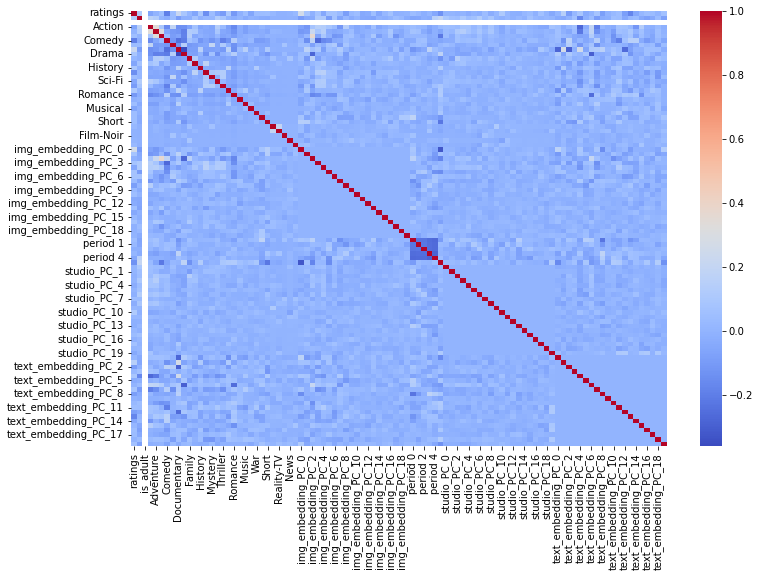

In [19]:
plt.figure(figsize=(12,8))
corr = preprocessed_data.corr()

heatmap = sns.heatmap(corr, cmap="coolwarm")

### Feature Selection


In [21]:
# Creer un data training/validation splités a partir du X1 (on garde X2 pour les vrais tests) 
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, Y1, test_size = 0.2, random_state=1)

In [23]:
# Score computation : Root Mean Square Error

def compute_rmse(predict, target):
    return mean_squared_error(predict, target, squared=False)

def compute_rmse2(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

In [32]:
from sklearn.feature_selection import mutual_info_regression
scores = mutual_info_regression(X_train, np.ravel(y_train))

### Linear Regression

In [ ]:
def fit_predict_with_features(X_train,Y_train, X_test, Y_test, selected_features):
    X_train_filtered = X_train[selected_features]
    X_test_filtered = X_test[selected_features]
    
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train_filtered,Y_train)
    print(clf.score(X_test_filtered, Y_test))
    y_pred = clf.predict(X_test_filtered)

    return y_pred

In [ ]:
print('By selecting features')
# Dans ce cas, on selectionne tout
Y_pred = fit_predict_with_features(X_train,y_train, X_test, y_test, X_train.columns)


### GridSearch on KNN

In [ ]:
def perform_grid_search(model_, params, scoring,X_train, y_train):

    clf = GridSearchCV(model_, params, cv=5, scoring=scoring, n_jobs=-1)
    grid_result = clf.fit(X_train,y_train)
    print("clf.best_score_: ", clf.best_score_)
    print("clf.best_params_: ",clf.best_params_)
    return grid_result
 
 
# Définir les valeurs à tester pour les hyperparamètres du modèle
params =    {'n_neighbors' : range(3, 40), 
            'weights' : ['uniform', 'distance']}
knn = KNeighborsRegressor(n_jobs=-1)
scoring = "neg_mean_squared_error"

grid = perform_grid_search(knn, params, scoring, X_train, y_train)
pred = grid.best_estimator_.predict(X_test)
print("pred: ",pred.mean())

print("Score")
model = grid.best_estimator_
print(model.score(X_test,y_test))
rmse = compute_rmse(pred, y_test)
rmse

In [ ]:
# Score for each training subset
N, train_score, val_score = learning_curve(knn, X_train, y_train, cv=5)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel("train size")
plt.legend()
plt.show()

In [ ]:
# Evaluation metrics from the gridsearch
res = pd.DataFrame(grid.cv_results_.values(), ).transpose()
res.columns=grid.cv_results_.keys()
res